00:19:17 - cmdstanpy - INFO - Chain [1] start processing


00:19:17 - cmdstanpy - INFO - Chain [1] done processing


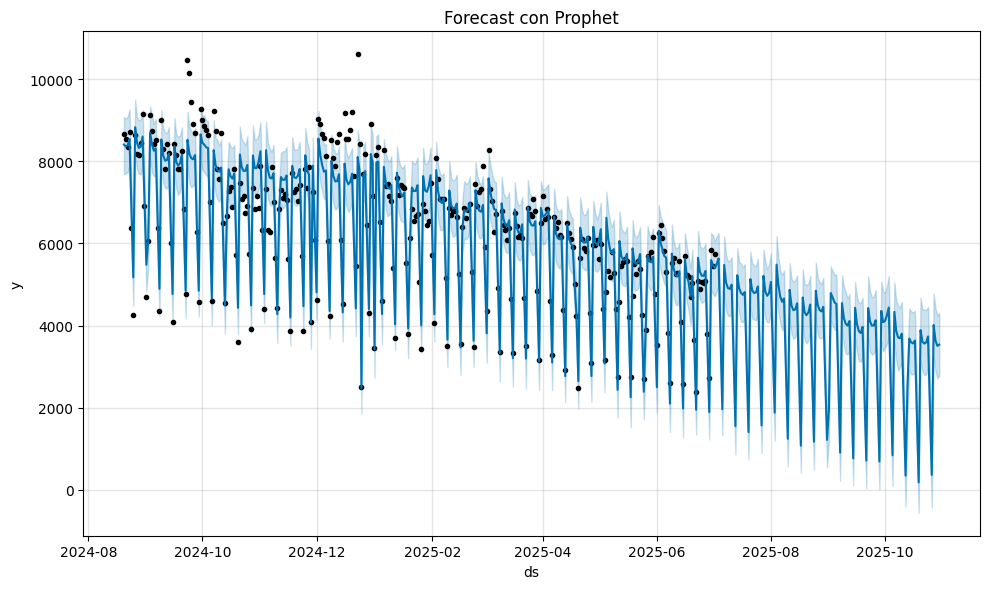

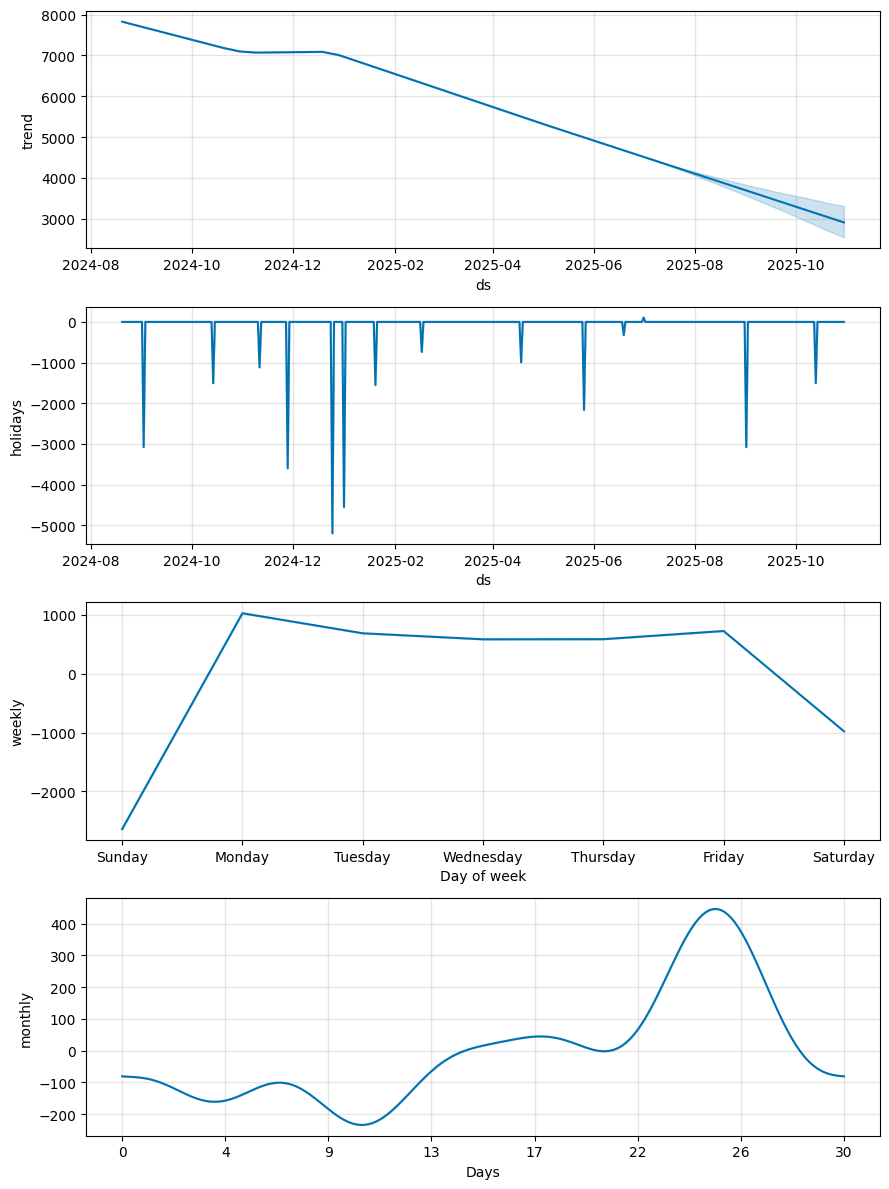

In [12]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from datetime import timedelta
from prophet.make_holidays import get_country_holidays_class

# Set Plotly to open in browser
pio.renderers.default = "browser"

# 1. Cargar el archivo Excel
df = pd.read_excel("data.xlsx", engine="openpyxl")

# 2. Limpiar datos
df = df.dropna(subset=["date", "calls", "skill"])
df = df[df["calls"] != 0]
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

# 3. Preparar datos para Prophet
df_prophet = df[["date", "calls"]].rename(columns={"date": "ds", "calls": "y"})

# 4. Crear festivos combinados para US y CA
start_year = df_prophet["ds"].min().year
end_year = (df_prophet["ds"].max() + timedelta(days=120)).year
years = list(range(start_year, end_year + 1))

def make_combined_holidays_df(countries, years):
    all_holidays = []
    for country in countries:
        country_class = get_country_holidays_class(country)
        holidays = country_class(years=years)
        df_holidays = pd.DataFrame({
            'ds': pd.to_datetime(list(holidays.keys())),
            'holiday': [', '.join(holidays.get_list(date)) for date in holidays]
        })
        all_holidays.append(df_holidays)
    return pd.concat(all_holidays, ignore_index=True)

holidays_df = make_combined_holidays_df(["US", "CA"], years)

# 5. Crear y entrenar el modelo Prophet
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    seasonality_mode='additive',
    holidays=holidays_df
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df_prophet)

# 6. Crear fechas para pronóstico
last_date = df_prophet["ds"].max()
future = model.make_future_dataframe(periods=120, freq='D')
past = pd.date_range(end=last_date, periods=90, freq='D')
all_dates = past.union(future["ds"])

# 7. Generar pronóstico
forecast = model.predict(pd.DataFrame({"ds": all_dates}))

# 8. Preparar tabla de resultados
result = forecast[["ds", "yhat"]].rename(columns={"ds": "date", "yhat": "forecast"})
calls_map = df_prophet.set_index("ds")["y"].to_dict()
result["calls"] = result["date"].map(calls_map).fillna(0)

# 9. Exportar a Excel
result.to_excel("forecast.xlsx", index=False)

# 10. Gráficas estándar de Prophet
model.plot(forecast)
plt.title("Forecast con Prophet")
plt.tight_layout()
plt.show()

model.plot_components(forecast)
plt.tight_layout()
plt.show()

# 11. Gráfica comparativa con Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=result["date"], y=result["forecast"], mode='lines', name='Pronóstico'))
fig.add_trace(go.Scatter(x=result["date"], y=result["calls"], mode='lines', name='Llamadas reales'))
fig.update_layout(title="Comparación de Pronóstico vs Llamadas Reales", xaxis_title="Fecha", yaxis_title="Llamadas")
fig.show()
